### Clustering of the AP3 fingerprints to evaluate the applicability for similarity search

In [1]:
import _pickle as cPickle
import gzip,time
from collections import defaultdict
import random
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
import utilsFunctions
from pylab import rcParams


Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"

with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)

# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

Load the transformation FPs 

In [4]:
infile = gzip.open(dataDir+"transformationFPs_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_AP3,fp_MG2,fp_TT = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_AP3])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


In [5]:
print(lineNo)

50001


Build a subset of the fingerprints (training set) (10000 FPs) for efficiency reasons.

In [5]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz= 256
fpsubset = []

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        trfp_AP3 = utilsFunctions.hashFP(fps[x][3],fpsz) # 256 bit
#         print((trfp_AP3).GetLength())
        trfp_AP3 = utilsFunctions.removeNegativeCountsFP(trfp_AP3) # 512 bit
#         print((trfp_AP3).GetLength())
        fpsubset.append((trfp_AP3,fps[x][2]))

Cluster this subset using the Butina algorithm from the RDKit with the Dice coefficent as similiarty metric and a threshold of 0.5 for similar FPs.

In [11]:
t1=time.time()
tf=[x[0] for x in fpsubset]
cs = Butina.ClusterData(tf,len(tf),0.5,distFunc=lambda x,y:1.-DataStructs.DiceSimilarity(x,y))
t2=time.time()

print('%.2f'%(t2-t1))
print(len(cs))




56.56
674


(array([620.,  15.,  10.,  12.,   3.,   4.,   2.,   0.,   1.,   0.,   1.,
          0.,   2.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  32.15,  63.3 ,  94.45, 125.6 , 156.75, 187.9 , 219.05,
        250.2 , 281.35, 312.5 , 343.65, 374.8 , 405.95, 437.1 , 468.25,
        499.4 , 530.55, 561.7 , 592.85, 624.  ]),
 <BarContainer object of 20 artists>)

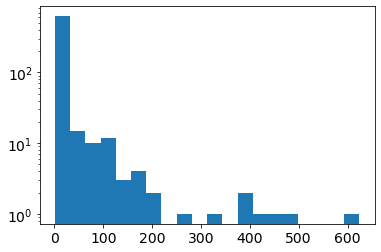

In [12]:
import matplotlib.pyplot as plt

plt.hist([len(x) for x in cs],bins=20,log=True)

Determine the purity of the clusters with at least ten members. The purity of the cluster is calculated by determining the main reaction type, class and super-class and normalizing this quantity by the size of the cluster.

In [23]:
import operator
purities=[]
nAccountedFor=0
for (i,c) in enumerate(cs):
    sz=len(c)
    if sz<=10:
        continue
    nAccountedFor+=sz
    tcounts1=defaultdict(int)
    tcounts2=defaultdict(int)
    tcounts3=defaultdict(int)
    for idx in c:
        lbl = fpsubset[idx][1]
        slbl = lbl.split(' ')[0].split('.')
        tcounts1[slbl[0]]+=1
        tcounts2['.'.join(slbl[:2])]+=1
        tcounts3['.'.join(slbl[:3])]+=1
        
    tcounts1_sorted = sorted(tcounts1.items(), key=operator.itemgetter(1), reverse=True) 
    maxc1 = tcounts1_sorted[0][1]
    maxlbl1 = tcounts1_sorted[0][0]
    tcounts2_sorted = sorted(tcounts2.items(), key=operator.itemgetter(1), reverse=True) 
    maxc2 = tcounts2_sorted[0][1]
    maxlbl2 = tcounts2_sorted[0][0]
    tcounts3_sorted = sorted(tcounts3.items(), key=operator.itemgetter(1), reverse=True) 
    maxc3 = tcounts3_sorted[0][1]
    maxlbl3 = tcounts3_sorted[0][0]
    purities.append((i,sz,(1.*maxc1/sz,1.*maxc2/sz,1.*maxc3/sz),(maxlbl1, maxlbl2, maxlbl3),(maxc1,maxc2,maxc3)))
print(len(purities),nAccountedFor)
# print(purities)

110 8652


Determine the number of members per reaction type, class and super-class in the FP subset.

In [24]:
members_rtype=defaultdict(int)
members_class=defaultdict(int)
members_superclass=defaultdict(int)
for i in fpsubset:
    members_rtype[i[1]]+=1
    members_class[i[1].split('.')[0]+'.'+i[1].split('.')[1]]+=1
    members_superclass[i[1].split('.')[0]]+=1
    
# print(members_rtype)
# print(members_class)
# print(members_superclass)

##### Calculate F-score, precision and recall for the reaction type purity of the clusters.

The mean purity per reaction type can be regarded as a kind of precision value. We were also interested in the recall, the number of reactions per reaction type which could be actually recovered within the clusters. Hence, the recall is calculated by the number of recovered reactions divided by number of reactions of that type contained in the data. Using the recall and precision the F-score of the clustering for each reaction type can be determined.

Merge the clusters with the same main reaction type and calculate based on this the mean F-score, precision and recall.

In [26]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
rtype_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_rtype, 2)

Mean F-score:  0.6197521931092068
Median F-score:  0.6149911816578484
Min, Max F-score : 0.9847715736040609 0.06572769953051644
Mean precision:  0.7509024456173475
Median precision:  0.7774371746974487
Min, Max precision : 1.0 0.32051282051282054
Mean recall:  0.5958695652173913
Median recall:  0.6275
Min, Max recall : 1.0 0.035


Sort the final clusters based on the number of clusters they were build of in ascending order.

In [27]:
rtype_purity_sorted = sorted(rtype_purity_dict.items(), key=operator.itemgetter(1))

Plot the distribution of the different reaction type clusters considering the number of clusters they were build of and their F-score. 

46


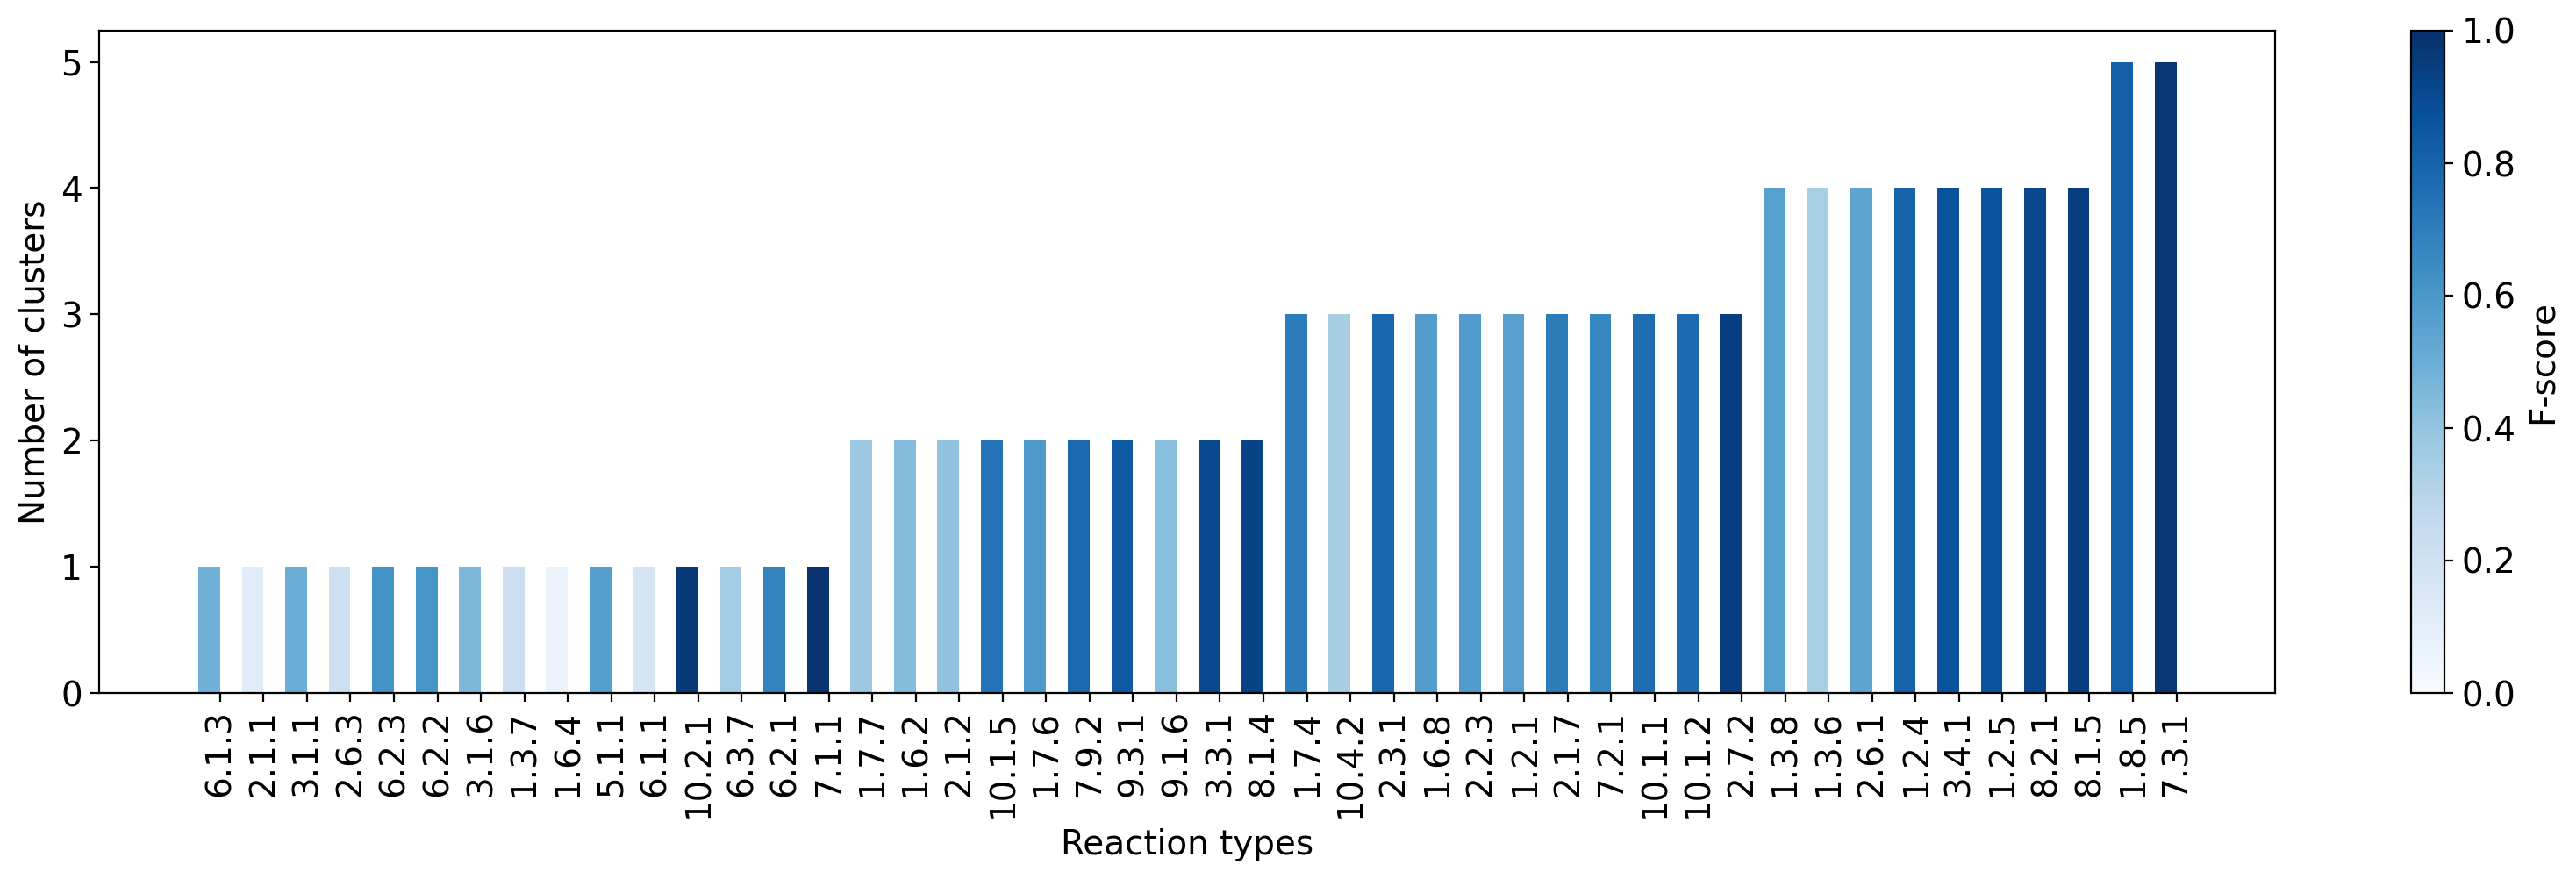

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

labels = [x[0] for x in rtype_purity_sorted]
yvalues1 = [x[1][0] for x in rtype_purity_sorted]
colors = [x[1][5] for x in rtype_purity_sorted]

xvalues = np.arange(len(rtype_purity_sorted))
print(len(xvalues))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width,color=plt.cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('Number of clusters')
plt.xlabel('Reaction types')
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues)
sm.set_array(colors)
cb = plt.colorbar(sm)
cb.set_label('F-score')

Merge the clusters with the same main reaction class and calculate based on this the mean F-score, precision and recall.

In [29]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
class_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_class, 1)

Mean F-score:  0.7388931955280776
Median F-score:  0.7907256592876224
Min, Max F-score : 0.9847715736040609 0.19819819819819817
Mean precision:  0.890710879160876
Median precision:  0.9267910011444493
Min, Max precision : 1.0 0.6884990253411306
Mean recall:  0.6754613095238096
Median recall:  0.7541666666666667
Min, Max recall : 0.99 0.11


Sort the final clusters based on their mean F-score in ascending order.

In [30]:
class_purity_sorted = sorted(class_purity_dict.items(), key=lambda x: x[1][5])

Plot the distribution of the different reaction class clusters their mean F-score. 

Text(0.5, 0, 'Reaction classes')

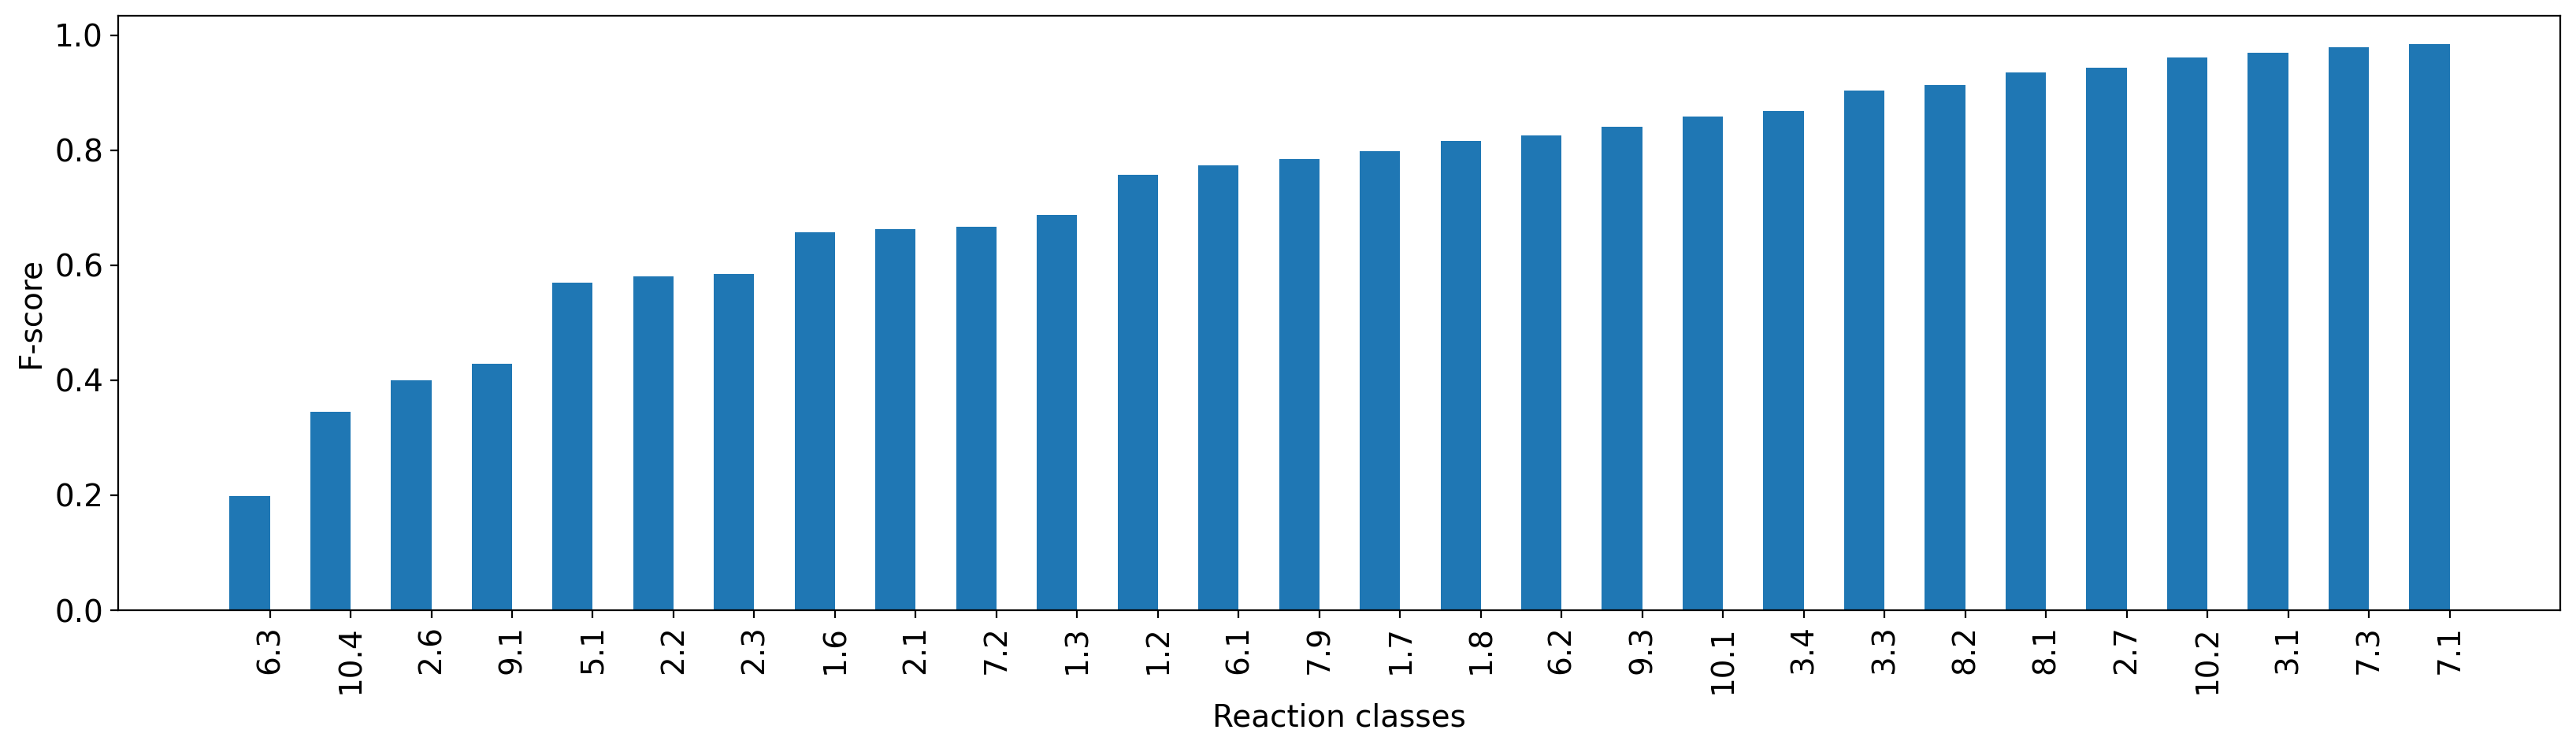

In [31]:
labels = [x[0] for x in class_purity_sorted]
yvalues1 = [x[1][5] for x in class_purity_sorted]
colors = [x[1][5] for x in class_purity_sorted]
xvalues = np.arange(len(class_purity_sorted))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width)#,color=cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('F-score')
plt.xlabel('Reaction classes')

Merge the clusters with the same main reaction super-class and calculate based on this the mean F-score, precision and recall.

In [33]:
# input purities list of the Butina clustering, number of members dict per reation type, class or super-class
# level: super-class = 0, class = 1, reation type = 2 
superclass_purity_dict = utilsFunctions.evaluatePurityClusters(purities, members_superclass, 0)

Mean F-score:  0.851032254901492
Median F-score:  0.9198569218870843
Min, Max F-score : 0.9705676273063956 0.5694444444444444
Mean precision:  0.9587821970378422
Median precision:  0.9821428571428572
Min, Max precision : 1.0 0.8366258116662297
Mean recall:  0.7799186507936509
Median recall:  0.865
Min, Max recall : 0.984375 0.41


Sort the final clusters based on their mean F-score in ascending order.

In [34]:
superclass_purity_sorted = sorted(superclass_purity_dict.items(), key=lambda x: x[1][5])

Plot the distribution of the different reaction super-class clusters their mean F-score. 

Text(0.5, 0, 'Reaction super-classes')

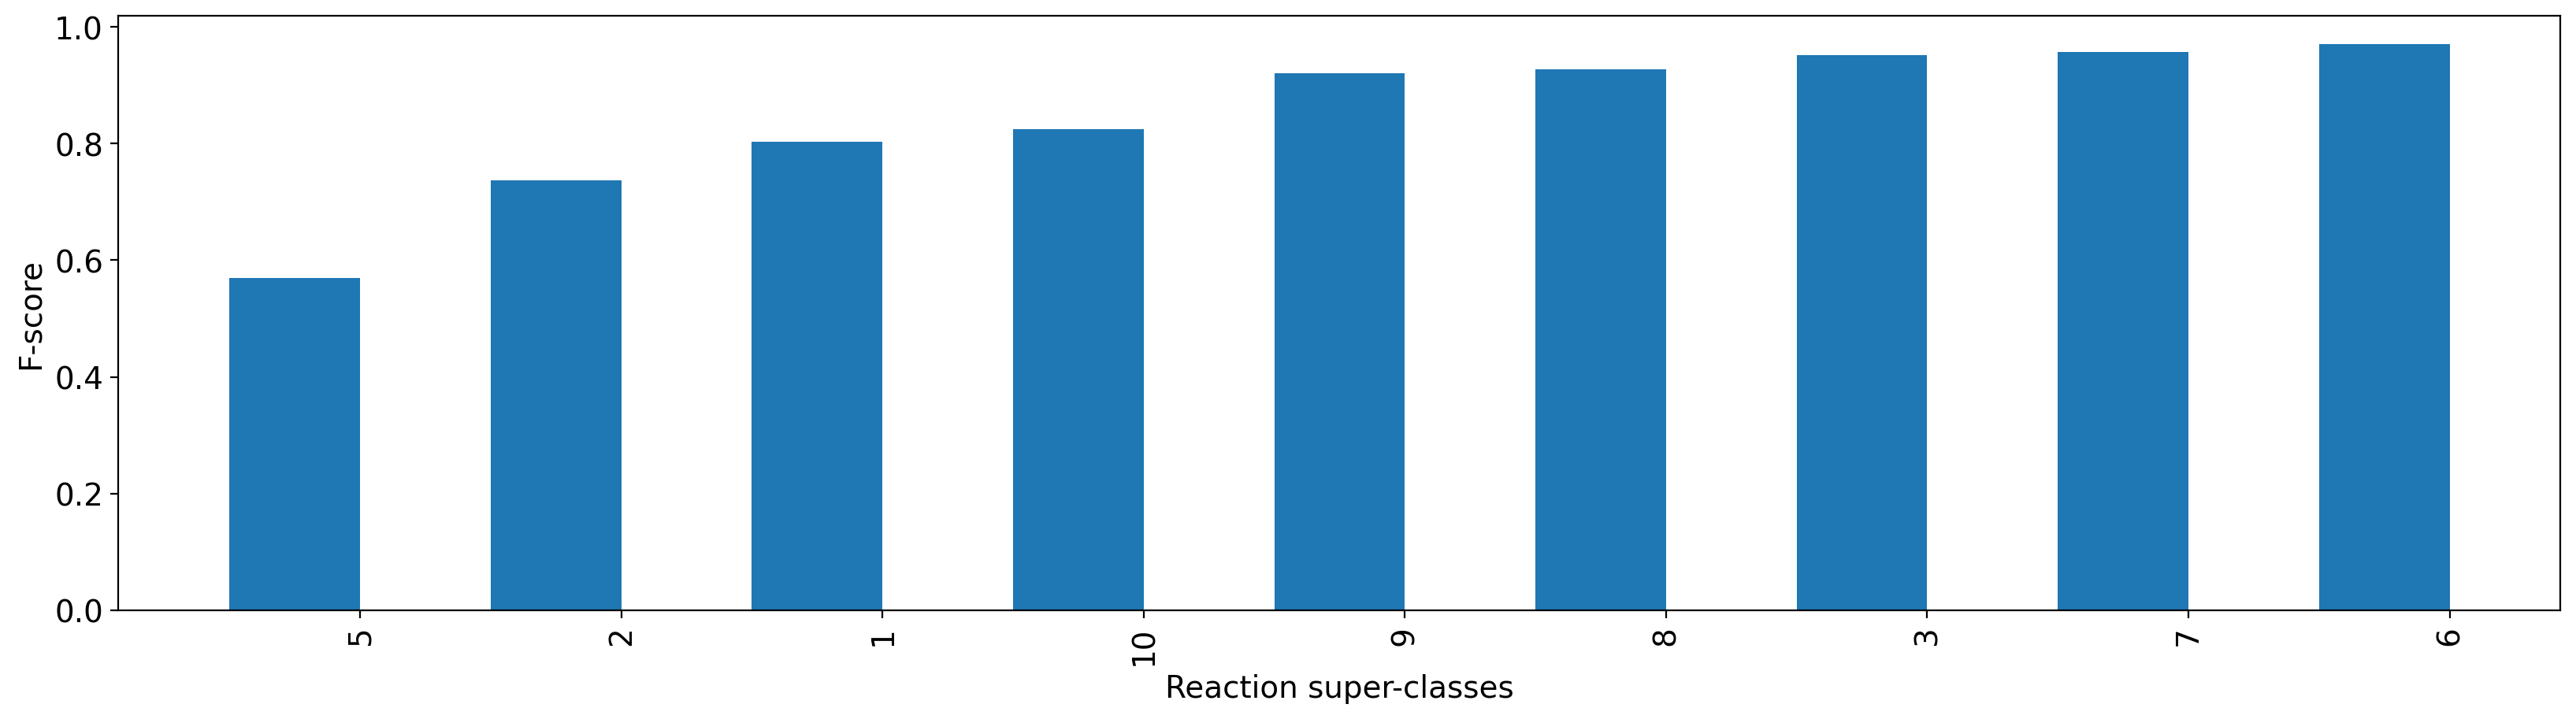

In [35]:
labels = [x[0] for x in superclass_purity_sorted]
yvalues1 = [x[1][5] for x in superclass_purity_sorted]
colors = [x[1][5] for x in superclass_purity_sorted]

xvalues = np.arange(len(superclass_purity_sorted))
colors.append(1.0) # to a scale from 0.0. to 1.0
colors.append(0.0) # to a scale from 0.0. to 1.0

width = 0.5
plt.figure(1,figsize=(20,5),dpi=200)
plt.subplot(1,1,1)
plt.bar(xvalues, yvalues1,width)#,color=cm.Blues(colors))
plt.xticks(xvalues+width/2., labels,rotation='vertical')
plt.ylabel('F-score')
plt.xlabel('Reaction super-classes')